In [2]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import pandas as pd

import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

from graph_gen import create_delegation_graph
import graph_tools
import networkx as nx

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [ ]:
range_x = range(0, 1001, 200)

time_data_le = []
time_data_lp = []
time_data_iterative = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        countdown = 5
        while countdown > 0:
            countdown -= 1

            dense_graph = nx.gnp_random_graph(num_nodes, p=0.50, directed=True)
            dense_graph = graph_tools.nx_graph_nodes_to_str(dense_graph)
            delegation_graph = graph_tools.prepare_graph(dense_graph.nodes(), dense_graph.edges(), sink_frac = 0.1)
            delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
            delegations = graph_tools.invert_graph(delegations_orig)
            nodes = list(delegation_graph)

            try: 
                lp_model = lp.set_up(delegations, nodes)
                _ = lp.resolve_delegations(delegations, nodes)
                break
            except:
                print(lp_model)
                SEED += 1
                print("Graph infeasible, retrying")

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (abs(powers_lp[node] - powers_iter[node]) < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 1
        if 0 <= num_nodes < 500:
            n = 5
        elif 500 <= num_nodes < 1000:
            n = 2

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes, cutoff=0.0001)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

0
0
0
0
0
0
200


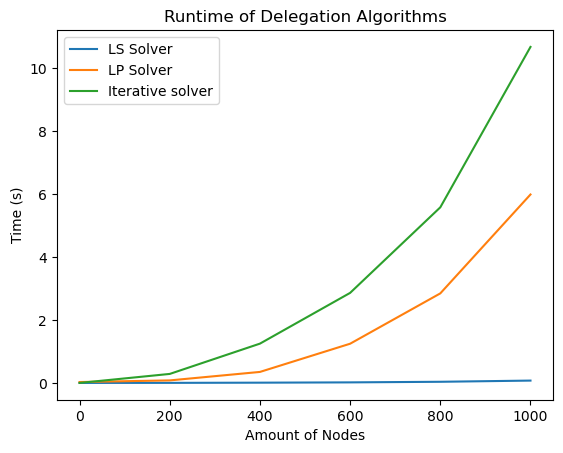

In [13]:
plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LS Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

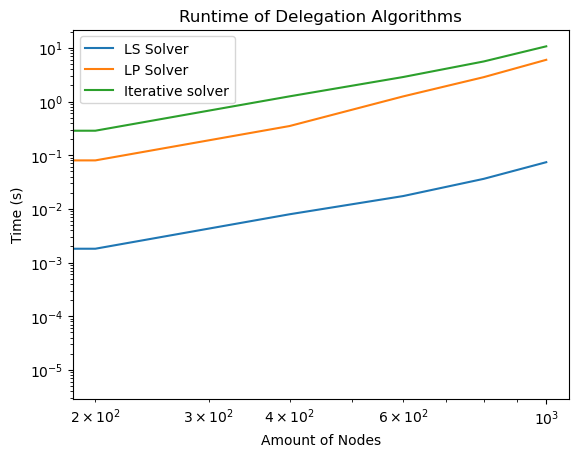

In [14]:
for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LS Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.loglog()
plt.show()

In [11]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

[0, 200, 400, 600, 800, 1000]
time_data_iterative
[[0.0002826213836669922, 0.28565258979797364, 1.2475532054901124, 2.858510375022888, 5.574770569801331, 10.667368173599243]]
time_data_le
[[5.865097045898438e-06, 0.00180816650390625, 0.007926368713378906, 0.0173109769821167, 0.036240458488464355, 0.07402801513671875]]
time_data_lp
[[0.02861161231994629, 0.07995662689208985, 0.3490918159484863, 1.2445429563522339, 2.8426239490509033, 5.9823009967803955]]


# Testing this to the extreme

In [4]:
range_x = range(0, 5001, 1000)

time_data_le = []
time_data_lp = []
time_data_iterative = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        dense_graph = nx.gnp_random_graph(num_nodes, p=0.50, directed=True)#dense_graph(num_nodes)
        dense_graph = nx.relabel_nodes(dense_graph, {node: str(node) for node in dense_graph.nodes()})
        delegation_graph = graph_tools.prepare_graph(dense_graph.nodes(), dense_graph.edges(), sink_frac = 0.1)
        delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
        delegations = graph_tools.invert_graph(delegations_orig)
        nodes = list(delegation_graph)

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (abs(powers_lp[node] - powers_iter[node]) < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 1
        if 0 <= num_nodes < 500:
            n = 5
        elif 500 <= num_nodes < 1000:
            n = 1

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes, cutoff=0.0001)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

0
1000
2000
3000
4000
5000


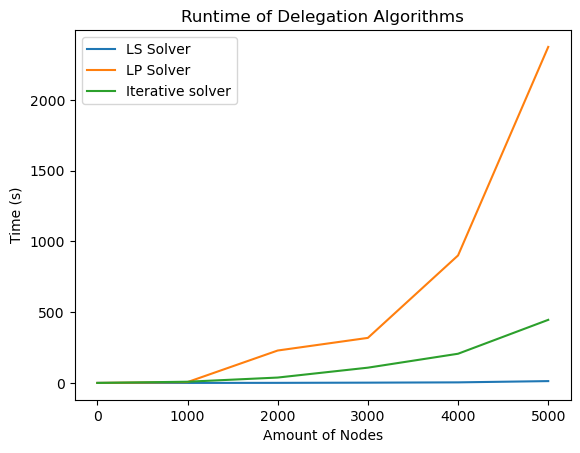

In [9]:
plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LS Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

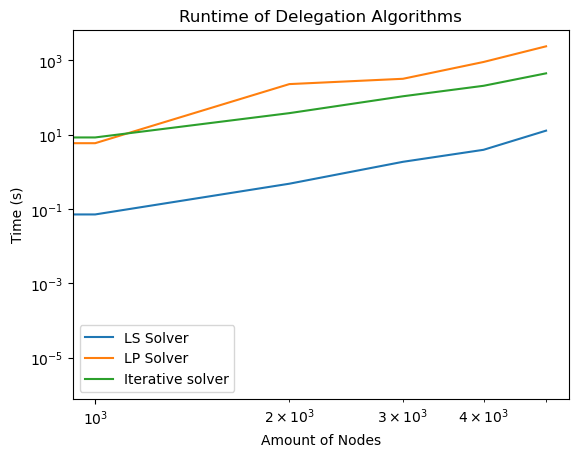

In [10]:
for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LS Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.loglog()
plt.show()

In [6]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

[0, 1000, 2000, 3000, 4000, 5000]
time_data_iterative
[[0.00021204948425292968, 8.423933029174805, 37.93428182601929, 107.81542682647705, 206.2341558933258, 445.81208086013794]]
time_data_le
[[2.193450927734375e-06, 0.07163715362548828, 0.48033618927001953, 1.8638660907745361, 3.9203078746795654, 12.830172061920166]]
time_data_lp
[[0.031383180618286134, 5.901510000228882, 229.01106905937195, 318.296835899353, 901.078891992569, 2374.9204790592194]]
